In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import HeNormal, GlorotNormal
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/패캠강의/fastcampus_recsys_2301/Fastcampus_Codes/03_DL_based_algorithms/')

Mounted at /content/drive


In [ ]:
# 무비렌즈 데이터 세트 호출
data_path = '../data/ml-latest-small/'
df = pd.read_csv(data_path+'ratings.csv')

In [ ]:
# binary implicit feedback
# rating >= 3.0일 경우 positive로 간주
df['rating'] = df['rating'].apply(lambda x: 1 if x >= 3.0 else 0)

# 전체 유저 수와 영화 수
n_users = df.userId.nunique()
n_movies = df.movieId.nunique()

# 데이터를 train/valid로 나눔
train, validation = train_test_split(df, test_size=0.2, random_state=42)

# 유저 아이디 indexing
unique_user_ids = df["userId"].unique()
userId_dict = {id: i for i, id in enumerate(unique_user_ids)}


# 영화 아이디 indexing
unique_movie_ids = df["movieId"].unique()
movieId_dict = {id: i for i, id in enumerate(unique_movie_ids)}

# 인덱싱 된 딕셔너리를 사용하여 ID 맵핑
train["userId"] = train["userId"].map(userId_dict)
train["movieId"] = train["movieId"].map(movieId_dict)

validation["userId"] = validation["userId"].map(userId_dict)
validation["movieId"] = validation["movieId"].map(movieId_dict)

# 전체 유니크 유저 수
num_unique_users = df['userId'].nunique() + 1
# 전체 유니크 영화 수
num_unique_movies = df['movieId'].nunique() + 1

In [ ]:
# 유저/아이템 입력 레이어
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

# 임베딩 차원
n_latent_factors = 20

# 임베딩 레이어 정의
user_embedding = Embedding(num_unique_users, n_latent_factors, name='user_embedding')(user_input)
movie_embedding = Embedding(num_unique_movies, n_latent_factors, name='movie_embedding')(movie_input)

# 임베딩 flatten
user_vector = Flatten()(user_embedding)
movie_vector = Flatten()(movie_embedding)

# 유저 및 영화 임베딩 벡터 컨캣
concat = Concatenate()([user_vector, movie_vector])

In [ ]:
# MLP 생성하는 함수 -> 원하는 형태로 블록처럼 쌓을 수 있음
def create_mlp(hidden_layers, output):
    for i in range(len(hidden_layers)):
        if i == 0:
            hidden = Dense(hidden_layers[i], activation='relu')(output)
        else:
            hidden = Dense(hidden_layers[i], activation='relu')(hidden)
    output = Dense(1, activation='sigmoid')(hidden)  # 이진 출력은 시그모이드 활성화로
    return output

# create_mlp 함수를 사용하여 MLP 모델 생성
output = create_mlp([64, 64], concat)

In [ ]:
# 최종 모델
model = Model(inputs=[user_input, movie_input], outputs=output)

In [ ]:
# 모델을 컴파일 -> auc 함수로 평가
auc = tf.keras.metrics.AUC()

In [ ]:
# 모델 요약
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 20)        12220       ['input_1[0][0]']                
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 20)        194500      ['input_2[0][0]']                
                                                                                              

In [ ]:
import matplotlib.pyplot as plt

# 로스 정보 업데이트 할 테이블
df = pd.DataFrame(columns=['Optimizer', 'Loss'])

# 모델 컴파일 -> 다른 옵티마이저 고려할 수 있도록
from tensorflow.keras.optimizers import SGD

custom_optimizer_momentum = SGD(learning_rate=0.01, momentum=0.9)
custom_optimizer_nag = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

optimizers = ['sgd', 'adagrad', custom_optimizer_momentum, custom_optimizer_nag,
              'rmsprop', 'adadelta', 'adam', 'nadam']


# 로스 기록용 딕셔너리
loss_history = {}

for optimizer in optimizers:

    # 유저/아이템 입력 레이어
    user_input = Input(shape=(1,))
    movie_input = Input(shape=(1,))

    # 임베딩 차원
    n_latent_factors = 20

    # 임베딩 레이어 정의
    user_embedding = Embedding(num_unique_users, n_latent_factors, name='user_embedding')(user_input)
    movie_embedding = Embedding(num_unique_movies, n_latent_factors, name='movie_embedding')(movie_input)

    # 임베딩 flatten
    user_vector = Flatten()(user_embedding)
    movie_vector = Flatten()(movie_embedding)

    # 유저 및 영화 임베딩 벡터 컨캣
    concat = Concatenate()([user_vector, movie_vector])

    output = create_mlp([64, 64], concat)

    # 최종 모델
    model = Model(inputs=[user_input, movie_input], outputs=output)

    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auc])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', auc])

    # 모델 적합
    history = model.fit([train.userId, train.movieId], train.rating, epochs=10,
                        verbose=2, validation_data=([validation.userId, validation.movieId], validation.rating))

    # 마지막 로스와 정확도 기록
    print(f"Optimizer: {optimizer}")
    print(f"Loss: {history.history['val_loss'][-1]}")
    print(f"Accuracy: {history.history['accuracy'][-1]}")

    df = df.append({'Optimizer': optimizer, 'Loss': history.history['val_loss'][-1]}, ignore_index=True)

    # 딕셔너리 업데이트
    loss_history[str(optimizer)] = history.history['val_loss']


Epoch 1/10
2521/2521 - 5s - loss: 0.4905 - accuracy: 0.8111 - auc: 0.5407 - val_loss: 0.4835 - val_accuracy: 0.8091 - val_auc: 0.6018 - 5s/epoch - 2ms/step
Epoch 2/10
2521/2521 - 4s - loss: 0.4754 - accuracy: 0.8113 - auc: 0.6345 - val_loss: 0.4718 - val_accuracy: 0.8091 - val_auc: 0.6657 - 4s/epoch - 1ms/step
Epoch 3/10
2521/2521 - 5s - loss: 0.4589 - accuracy: 0.8113 - auc: 0.6900 - val_loss: 0.4520 - val_accuracy: 0.8091 - val_auc: 0.7075 - 5s/epoch - 2ms/step
Epoch 4/10
2521/2521 - 4s - loss: 0.4396 - accuracy: 0.8134 - auc: 0.7210 - val_loss: 0.4370 - val_accuracy: 0.8130 - val_auc: 0.7265 - 4s/epoch - 2ms/step
Epoch 5/10
2521/2521 - 4s - loss: 0.4283 - accuracy: 0.8177 - auc: 0.7387 - val_loss: 0.4302 - val_accuracy: 0.8151 - val_auc: 0.7380 - 4s/epoch - 2ms/step
Epoch 6/10
2521/2521 - 5s - loss: 0.4214 - accuracy: 0.8191 - auc: 0.7510 - val_loss: 0.4254 - val_accuracy: 0.8155 - val_auc: 0.7458 - 5s/epoch - 2ms/step
Epoch 7/10
2521/2521 - 4s - loss: 0.4155 - accuracy: 0.8201 - au

<ipython-input-17-49e5bda67372>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Optimizer': optimizer, 'Loss': history.history['val_loss'][-1]}, ignore_index=True)


2521/2521 - 5s - loss: 0.5614 - accuracy: 0.8101 - auc: 0.5585 - val_loss: 0.5012 - val_accuracy: 0.8091 - val_auc: 0.5200 - 5s/epoch - 2ms/step
Epoch 2/10
2521/2521 - 3s - loss: 0.4879 - accuracy: 0.8113 - auc: 0.5160 - val_loss: 0.4863 - val_accuracy: 0.8091 - val_auc: 0.5654 - 3s/epoch - 1ms/step
Epoch 3/10
2521/2521 - 3s - loss: 0.4824 - accuracy: 0.8113 - auc: 0.5725 - val_loss: 0.4844 - val_accuracy: 0.8091 - val_auc: 0.5967 - 3s/epoch - 1ms/step
Epoch 4/10
2521/2521 - 3s - loss: 0.4806 - accuracy: 0.8113 - auc: 0.6044 - val_loss: 0.4825 - val_accuracy: 0.8091 - val_auc: 0.6231 - 3s/epoch - 1ms/step
Epoch 5/10
2521/2521 - 4s - loss: 0.4785 - accuracy: 0.8113 - auc: 0.6301 - val_loss: 0.4802 - val_accuracy: 0.8091 - val_auc: 0.6420 - 4s/epoch - 1ms/step
Epoch 6/10
2521/2521 - 3s - loss: 0.4760 - accuracy: 0.8113 - auc: 0.6512 - val_loss: 0.4775 - val_accuracy: 0.8091 - val_auc: 0.6594 - 3s/epoch - 1ms/step
Epoch 7/10
2521/2521 - 3s - loss: 0.4730 - accuracy: 0.8113 - auc: 0.6675 -

<ipython-input-17-49e5bda67372>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Optimizer': optimizer, 'Loss': history.history['val_loss'][-1]}, ignore_index=True)


2521/2521 - 5s - loss: 0.4436 - accuracy: 0.8148 - auc: 0.6957 - val_loss: 0.4210 - val_accuracy: 0.8162 - val_auc: 0.7597 - 5s/epoch - 2ms/step
Epoch 2/10
2521/2521 - 4s - loss: 0.3965 - accuracy: 0.8266 - auc: 0.7902 - val_loss: 0.4029 - val_accuracy: 0.8251 - val_auc: 0.7873 - 4s/epoch - 2ms/step
Epoch 3/10
2521/2521 - 5s - loss: 0.3728 - accuracy: 0.8365 - auc: 0.8219 - val_loss: 0.3979 - val_accuracy: 0.8239 - val_auc: 0.7927 - 5s/epoch - 2ms/step
Epoch 4/10
2521/2521 - 4s - loss: 0.3581 - accuracy: 0.8450 - auc: 0.8384 - val_loss: 0.3968 - val_accuracy: 0.8238 - val_auc: 0.7985 - 4s/epoch - 2ms/step
Epoch 5/10
2521/2521 - 5s - loss: 0.3468 - accuracy: 0.8517 - auc: 0.8495 - val_loss: 0.3978 - val_accuracy: 0.8269 - val_auc: 0.7990 - 5s/epoch - 2ms/step
Epoch 6/10
2521/2521 - 4s - loss: 0.3375 - accuracy: 0.8573 - auc: 0.8586 - val_loss: 0.4044 - val_accuracy: 0.8314 - val_auc: 0.7995 - 4s/epoch - 2ms/step
Epoch 7/10
2521/2521 - 4s - loss: 0.3305 - accuracy: 0.8601 - auc: 0.8653 -

<ipython-input-17-49e5bda67372>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Optimizer': optimizer, 'Loss': history.history['val_loss'][-1]}, ignore_index=True)


2521/2521 - 6s - loss: 0.4583 - accuracy: 0.8124 - auc: 0.6882 - val_loss: 0.4282 - val_accuracy: 0.8103 - val_auc: 0.7462 - 6s/epoch - 2ms/step
Epoch 2/10
2521/2521 - 4s - loss: 0.4067 - accuracy: 0.8232 - auc: 0.7737 - val_loss: 0.4021 - val_accuracy: 0.8246 - val_auc: 0.7850 - 4s/epoch - 2ms/step
Epoch 3/10
2521/2521 - 4s - loss: 0.3781 - accuracy: 0.8351 - auc: 0.8151 - val_loss: 0.3973 - val_accuracy: 0.8273 - val_auc: 0.7921 - 4s/epoch - 2ms/step
Epoch 4/10
2521/2521 - 5s - loss: 0.3615 - accuracy: 0.8437 - auc: 0.8346 - val_loss: 0.3947 - val_accuracy: 0.8262 - val_auc: 0.7973 - 5s/epoch - 2ms/step
Epoch 5/10
2521/2521 - 4s - loss: 0.3483 - accuracy: 0.8518 - auc: 0.8479 - val_loss: 0.3925 - val_accuracy: 0.8299 - val_auc: 0.7996 - 4s/epoch - 2ms/step
Epoch 6/10
2521/2521 - 5s - loss: 0.3384 - accuracy: 0.8565 - auc: 0.8577 - val_loss: 0.4023 - val_accuracy: 0.8302 - val_auc: 0.7987 - 5s/epoch - 2ms/step
Epoch 7/10
2521/2521 - 4s - loss: 0.3305 - accuracy: 0.8612 - auc: 0.8648 -

<ipython-input-17-49e5bda67372>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Optimizer': optimizer, 'Loss': history.history['val_loss'][-1]}, ignore_index=True)


2521/2521 - 5s - loss: 0.4246 - accuracy: 0.8246 - auc: 0.7480 - val_loss: 0.4150 - val_accuracy: 0.8290 - val_auc: 0.7640 - 5s/epoch - 2ms/step
Epoch 2/10
2521/2521 - 5s - loss: 0.3912 - accuracy: 0.8382 - auc: 0.7872 - val_loss: 0.4150 - val_accuracy: 0.8279 - val_auc: 0.7708 - 5s/epoch - 2ms/step
Epoch 3/10
2521/2521 - 4s - loss: 0.3795 - accuracy: 0.8446 - auc: 0.8008 - val_loss: 0.4134 - val_accuracy: 0.8301 - val_auc: 0.7737 - 4s/epoch - 2ms/step
Epoch 4/10
2521/2521 - 4s - loss: 0.3732 - accuracy: 0.8482 - auc: 0.8072 - val_loss: 0.4172 - val_accuracy: 0.8267 - val_auc: 0.7747 - 4s/epoch - 2ms/step
Epoch 5/10
2521/2521 - 5s - loss: 0.3689 - accuracy: 0.8498 - auc: 0.8118 - val_loss: 0.4129 - val_accuracy: 0.8260 - val_auc: 0.7736 - 5s/epoch - 2ms/step
Epoch 6/10
2521/2521 - 4s - loss: 0.3646 - accuracy: 0.8537 - auc: 0.8153 - val_loss: 0.4115 - val_accuracy: 0.8276 - val_auc: 0.7748 - 4s/epoch - 2ms/step
Epoch 7/10
2521/2521 - 4s - loss: 0.3597 - accuracy: 0.8573 - auc: 0.8196 -

<ipython-input-17-49e5bda67372>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Optimizer': optimizer, 'Loss': history.history['val_loss'][-1]}, ignore_index=True)


2521/2521 - 17s - loss: 0.6859 - accuracy: 0.7647 - auc: 0.5561 - val_loss: 0.6798 - val_accuracy: 0.8087 - val_auc: 0.5061 - 17s/epoch - 7ms/step
Epoch 2/10
2521/2521 - 9s - loss: 0.6723 - accuracy: 0.8113 - auc: 0.5084 - val_loss: 0.6648 - val_accuracy: 0.8091 - val_auc: 0.5120 - 9s/epoch - 4ms/step
Epoch 3/10
2521/2521 - 7s - loss: 0.6558 - accuracy: 0.8113 - auc: 0.5025 - val_loss: 0.6472 - val_accuracy: 0.8091 - val_auc: 0.5011 - 7s/epoch - 3ms/step
Epoch 4/10
2521/2521 - 7s - loss: 0.6372 - accuracy: 0.8113 - auc: 0.5033 - val_loss: 0.6280 - val_accuracy: 0.8091 - val_auc: 0.5027 - 7s/epoch - 3ms/step
Epoch 5/10
2521/2521 - 7s - loss: 0.6173 - accuracy: 0.8113 - auc: 0.5014 - val_loss: 0.6078 - val_accuracy: 0.8091 - val_auc: 0.5025 - 7s/epoch - 3ms/step
Epoch 6/10
2521/2521 - 6s - loss: 0.5969 - accuracy: 0.8113 - auc: 0.5025 - val_loss: 0.5879 - val_accuracy: 0.8091 - val_auc: 0.5045 - 6s/epoch - 2ms/step
Epoch 7/10
2521/2521 - 7s - loss: 0.5772 - accuracy: 0.8113 - auc: 0.5053

<ipython-input-17-49e5bda67372>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Optimizer': optimizer, 'Loss': history.history['val_loss'][-1]}, ignore_index=True)


2521/2521 - 7s - loss: 0.4087 - accuracy: 0.8263 - auc: 0.7250 - val_loss: 0.3922 - val_accuracy: 0.8314 - val_auc: 0.7984 - 7s/epoch - 3ms/step
Epoch 2/10
2521/2521 - 6s - loss: 0.3503 - accuracy: 0.8509 - auc: 0.8442 - val_loss: 0.3955 - val_accuracy: 0.8283 - val_auc: 0.7998 - 6s/epoch - 2ms/step
Epoch 3/10
2521/2521 - 7s - loss: 0.3195 - accuracy: 0.8655 - auc: 0.8726 - val_loss: 0.4042 - val_accuracy: 0.8286 - val_auc: 0.7958 - 7s/epoch - 3ms/step
Epoch 4/10
2521/2521 - 6s - loss: 0.2927 - accuracy: 0.8774 - auc: 0.8944 - val_loss: 0.4275 - val_accuracy: 0.8229 - val_auc: 0.7882 - 6s/epoch - 2ms/step
Epoch 5/10
2521/2521 - 7s - loss: 0.2695 - accuracy: 0.8869 - auc: 0.9116 - val_loss: 0.4491 - val_accuracy: 0.8195 - val_auc: 0.7771 - 7s/epoch - 3ms/step
Epoch 6/10
2521/2521 - 6s - loss: 0.2461 - accuracy: 0.8974 - auc: 0.9272 - val_loss: 0.4897 - val_accuracy: 0.8188 - val_auc: 0.7666 - 6s/epoch - 2ms/step
Epoch 7/10
2521/2521 - 7s - loss: 0.2209 - accuracy: 0.9081 - auc: 0.9420 -

<ipython-input-17-49e5bda67372>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Optimizer': optimizer, 'Loss': history.history['val_loss'][-1]}, ignore_index=True)


2521/2521 - 9s - loss: 0.4081 - accuracy: 0.8266 - auc: 0.7531 - val_loss: 0.3904 - val_accuracy: 0.8295 - val_auc: 0.8016 - 9s/epoch - 4ms/step
Epoch 2/10
2521/2521 - 7s - loss: 0.3482 - accuracy: 0.8512 - auc: 0.8463 - val_loss: 0.3927 - val_accuracy: 0.8312 - val_auc: 0.8016 - 7s/epoch - 3ms/step
Epoch 3/10
2521/2521 - 8s - loss: 0.3172 - accuracy: 0.8656 - auc: 0.8747 - val_loss: 0.4143 - val_accuracy: 0.8311 - val_auc: 0.7968 - 8s/epoch - 3ms/step
Epoch 4/10
2521/2521 - 8s - loss: 0.2919 - accuracy: 0.8767 - auc: 0.8956 - val_loss: 0.4263 - val_accuracy: 0.8229 - val_auc: 0.7893 - 8s/epoch - 3ms/step
Epoch 5/10
2521/2521 - 7s - loss: 0.2706 - accuracy: 0.8854 - auc: 0.9112 - val_loss: 0.4463 - val_accuracy: 0.8222 - val_auc: 0.7823 - 7s/epoch - 3ms/step
Epoch 6/10
2521/2521 - 8s - loss: 0.2494 - accuracy: 0.8942 - auc: 0.9252 - val_loss: 0.4755 - val_accuracy: 0.8218 - val_auc: 0.7755 - 8s/epoch - 3ms/step
Epoch 7/10
2521/2521 - 7s - loss: 0.2246 - accuracy: 0.9060 - auc: 0.9397 -

<ipython-input-17-49e5bda67372>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Optimizer': optimizer, 'Loss': history.history['val_loss'][-1]}, ignore_index=True)


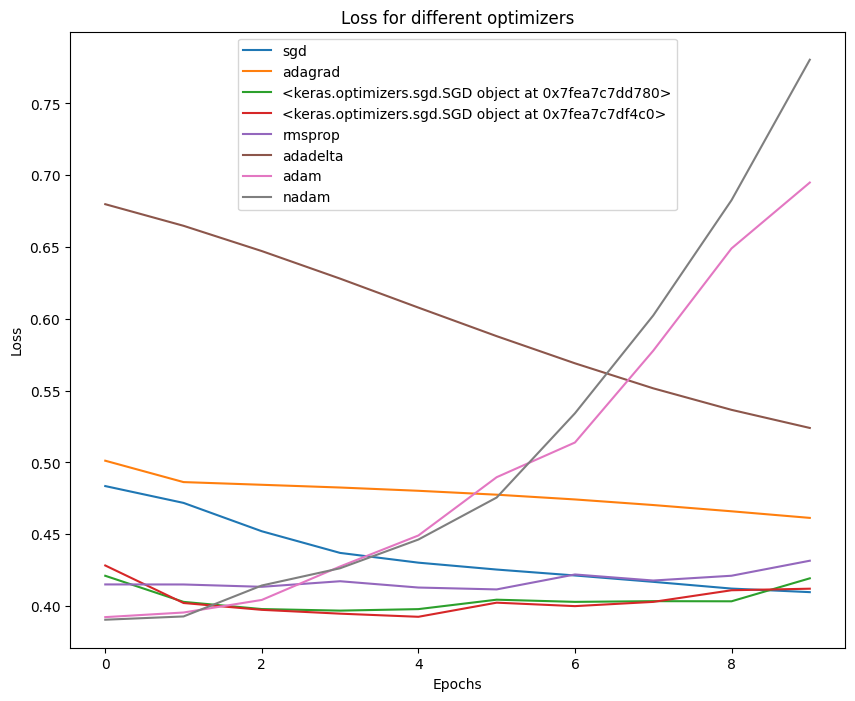

In [ ]:
# 로스 시각화
plt.figure(figsize=(10, 8))

for optimizer, losses in loss_history.items():
    plt.plot(losses, label=optimizer)

plt.title("Loss for different optimizers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


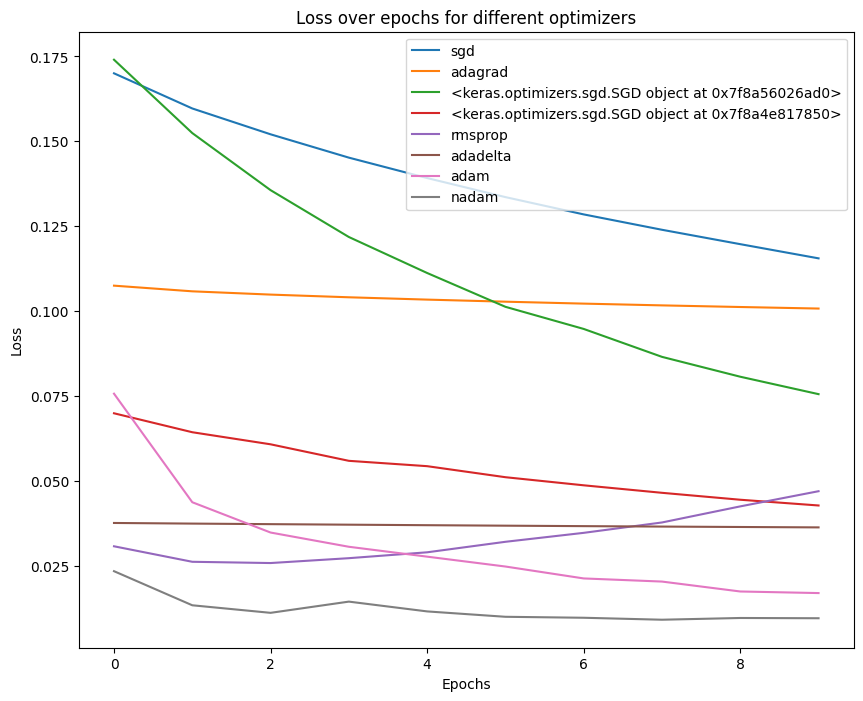

In [ ]:

# 로스 시각화
plt.figure(figsize=(10, 8))

for optimizer, losses in loss_history.items():
    plt.plot(losses, label=optimizer)

plt.title("Loss for different optimizers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
display(df)

,Optimizer,Loss
0,sgd,0.733085
1,adagrad,0.762385
2,<keras.optimizers.sgd.SGD object at 0x7f8a5602...,1.142803
3,<keras.optimizers.sgd.SGD object at 0x7f8a4e81...,1.554148
4,rmsprop,1.869895
5,adadelta,1.853010
6,adam,2.220196
7,nadam,2.757344
